In [1]:
import pandas as pd
import spacy
import re
import numpy as np
from tqdm import tqdm

from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

### Anime Recommendations Database
This exercise is based on Kaggle Anime Recommendation that was hosted in 2017. To make things more relevant for us, we will also practice some webscraping to update the information in the original dataset. Additionally, we will also see if we can extract more information to improve our recommendation system. 

For more information on how the web scraping was done, please explore the scraping folder. You can find the dataset we obtained from scraping in the data folder. 


### Pre-processing of data scraped 
We have previously scraped the anime information from the popular anime website. As the original data is from HTML format, we will have to perform some pre-processing to clean the text before performing text analytics to extract features that we can use for content-based recommendation system. We will also map the names from the original kaggle dataset to our scraped data as we did not scrape the anime names.

In [2]:
file_path = r"C:\Users\chest\Desktop\Projects\Anime Recommendation\data"
anime = pd.read_csv(file_path + "\\anime_scraped.csv", index_col=0)
anime.ID = anime.ID.astype("int32")
anime.Member = anime.Member.astype("int32")
anime.Genre = anime.Genre.astype("str")

#original dataset 
anime_original = pd.read_csv(file_path + "\\anime.csv", index_col=0)

#Get anime names based on index
anime.insert(0, "Name",anime_original.loc[anime.ID, "name"].values)
anime.head(3)

,Name,Duration,Episode,Fav,Genre,ID,Image,Member,Producer,Rating,Score,Source,Status,Studio,Synopsis,Type
0,Kimi no Na wa.,1 hr. 46 min.,1,53100.0,"Romance, Supernatural, School, Drama",32281,https://cdn.myanimelist.net/images/anime/5/870...,1132783,"Toho, Sound Team Don Juan, Lawson HMV Entertai...",PG-13 - Teens 13 or older,9.09,Original,Finished Airing,CoMix Wave Films,"['Mitsuha Miyamizu, a high school girl, yearns...",Movie
1,Fullmetal Alchemist: Brotherhood,24 min. per ep.,64,139870.0,"Action, Military, Adventure, Comedy, Drama, Ma...",5114,https://cdn.myanimelist.net/images/anime/1223/...,1609015,"Aniplex, Square Enix, Mainichi Broadcasting Sy...",R - 17+ (violence & profanity),9.23,Manga,Finished Airing,Bones,"['""In order for something to be obtained, some...",TV
2,Gintama°,24 min. per ep.,51,7556.0,"Action, Comedy, Historical, Parody, Samurai, S...",28977,https://cdn.myanimelist.net/images/anime/3/720...,280325,"TV Tokyo, Aniplex, Dentsu",PG-13 - Teens 13 or older,9.05,Manga,Finished Airing,Bandai Namco Pictures,"[""Gintoki, Shinpachi, and Kagura return as the...",TV


We will now convert the duration from string format into number of seconds. The duration is a useful feature as we presume some users might be more interested in shorter or longer animes.

In [3]:
anime = anime.assign(hours = anime["Duration"].str.extract(r"(\d+)(?=\s+hr\.)"),
                     mins = anime["Duration"].str.extract(r"(\d+)(?=\s+min\.)"),
                     secs = anime["Duration"].str.extract(r"(\d+)(?=\s+sec\.)"))
anime.loc[:,['hours', 'mins', 'secs']] = anime.loc[:,['hours', 'mins', 'secs']].fillna(0)
anime.loc[:,['hours', 'mins', 'secs']] = anime.loc[:,['hours', 'mins', 'secs']].apply(pd.to_numeric)
anime["Duration_Sec"] = anime.loc[:,['hours', 'mins', 'secs']].apply(lambda x: (x.hours * 3600) + (x.mins * 60) + x.secs, axis=1)
anime = anime.drop(["Duration", "hours", "mins", "secs"], axis=1)

anime.loc[[0,1,2], ["ID", "Duration_Sec"]]

,ID,Duration_Sec
0,32281,6360
1,5114,1440
2,28977,1440


We will now clean up the synopsis column which will be used to extract features for the recommendation system. There are still some imperfections in the dataset after cleaning. For instance, instead of the writer signing off with a bracket or paranthesis, the sign off is done in the form of a sentence. To clean off such variation can be very time consuming and might not be worth the effort.

In [4]:
#pre-processing synopsis text (Text used in content based recommendation system)
anime["Synopsis_clean"] = anime["Synopsis"].apply(lambda x: re.sub(r"(^\W+)", "", x))  
anime["Synopsis_clean"] = anime["Synopsis_clean"].apply(lambda x: re.sub(r"(\[.+\]$)", "", x)) # remove end writer
anime["Synopsis_clean"] = anime["Synopsis_clean"].apply(lambda x: re.sub(r"\\r", "", x)) # remove carriage return
anime["Synopsis_clean"] = anime["Synopsis_clean"].apply(lambda x: re.sub(r"\\n", "", x)) # remove new lines
anime["Synopsis_clean"] = anime["Synopsis_clean"].apply(lambda x: re.sub(r'"', "", x))
anime["Synopsis_clean"] = anime["Synopsis_clean"].apply(lambda x: re.sub(r"'", "", x))
anime["Synopsis_clean"] = anime["Synopsis_clean"].apply(lambda x: re.sub(r"\\", "", x))
anime["Synopsis_clean"] = anime["Synopsis_clean"].apply(lambda x: re.sub(r",", "", x))
anime["Synopsis_clean"] = anime["Synopsis_clean"].apply(lambda x: re.sub(r"\(.+\)\]$", "", x)) # remove end writer in ()

<u>Original synopsis before cleaning</u>

In [5]:
anime.loc[3, "Synopsis"]

'[\'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel.\', \'\\r\\n\', "\\r\\nThough miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history.", \'\\r\\n\', \'\\r\\nAdapted from the critically acclaimed visual novel by 5pb. and Nitroplus, \', \' takes Okab

<u>Synopsis after cleaning</u>

In [6]:
anime.loc[3, "Synopsis_clean"]

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara where he indulges himself in his hobby of inventing prospective future gadgets with fellow lab members: Mayuri Shiina his air-headed childhood friend and Hashida Itaru a perverted hacker nicknamed Daru. The three pass the time by tinkering with their most promising contraption yet a machine dubbed the Phone Microwave which performs the strange function of morphing bananas into piles of green gel.  Though miraculous in itself the phenomenon doesnt provide anything concrete in Okabes search for a scientific breakthrough; that is until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past altering the flow of history.  Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus   takes Okabe through the depths of scientific theory and practicality. Forced acr

To make the text analytics in the next step more efficient, we will be removing synopsis that are either empty or have minimal information. We will plot a histogram to get a sense of the frequency distribution of the number of words. There is a significant group of anime with synopsis word count less than 30. Thus, we will use a threshold of 15 to remove anime that we believe have minimal information in their synopsis to be relevant to the context-based system.

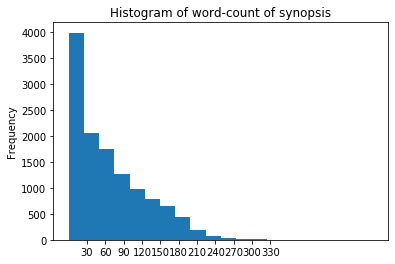

In [7]:
anime["Synopsis_count"] = anime["Synopsis_clean"].apply(lambda x: len(word_tokenize(x)))
anime["Synopsis_count"].plot.hist(bins=20, 
                                  xticks=[i for i in range(30,350,30)],
                                  title="Histogram of word-count of synopsis")
content_anime = anime[anime["Synopsis_count"] >= 15]

### Using Spacy to perform text analytics task
Spacy is a NLP package that has a variety of functions from vector similarity to POS tagging. Vector similarity is based on tha a pre-trained model downloaded from Spacy. There are 3 versions, namely, small, medium and large. The larger the pre-trained model, the better the results but at the expense of longer computational time.

We will be using Spacy for POS tagging and NER. The features from POS tagging and NER will be used to help us build our recommendation system. This is a slight twist to the general content-based system where text is pre-processed and transformed into a matrix of tf-idf. One of the drawback of the general content-based system is a sparse matrix. A sparse matrix leads to computational inefficiency and also lower effectiveness. In the event where there is very limited overlapping words, the recommendation system will be ineffective for such a word-of-bag method.

Alternatively, We will try to re-create a matrix with features that we obtained from POS tagging NER. The outcome that we hope to achieve through this process is to create a denser representation. 

The following is a demo of what is going underneath the hood for the feature extraction.

1. Extract NER that we think are insightful.
2. Extract words that are tagged as NOUN, VERB and ADJ.
3. Lemmatize the features 

As mentioned earlier that larger model tend to perform better, try running both the small model and medium model. You will notice that the results of the NER model changes. For this exercise, we will not be using large due to limited computational power on my local machine.

In [8]:
# Initiate Spacy Object
nlp = spacy.load("en_core_web_md")
doc = nlp(anime.loc[0, "Synopsis_clean"])
doc

Mitsuha Miyamizu a high school girl yearns to live the life of a boy in the bustling city of Tokyo—a dream that stands in stark contrast to her present life in the countryside. Meanwhile in the city Taki Tachibana lives a busy life as a high school student while juggling his part-time job and hopes for a future in architecture.  One day Mitsuha awakens in a room that is not her own and suddenly finds herself living the dream life in Tokyo—but in Takis body! Elsewhere Taki finds himself living Mitsuhas life in the humble countryside. In pursuit of an answer to this strange phenomenon they begin to search for one another.    revolves around Mitsuha and Takis actions which begin to have a dramatic impact on each others lives weaving them into a fabric held together by fate and circumstance.  

In [9]:
ner_body = [] 
meaningful_ner = ["GPE", "NORP", "EVENT", "LOC", "LANGUAGE", 
                  "ORG", "PRODUCT", "FAC", "LAW", "WORK_OF_ART"]
for ent in doc.ents: 
    if ent.label_ in meaningful_ner:
        ner_body.append(ent.text)
" ".join(ner_body)

'Tokyo Tokyo Takis'

In [10]:
pos_body = []
for token in doc:
    if token.pos_ in ["NOUN", "ADJ", "VERB"]:
        pos_body.append(token.text) # To only extract Verb, Noun, ADJ
" ".join(pos_body) # For illustration on the notebook, we will cut short the pos_body

'high school girl yearns live life boy bustling city dream stands stark contrast present life countryside city lives busy life high school student juggling part time job hopes future architecture day awakens room own finds living dream life body finds living life humble countryside pursuit answer strange phenomenon begin search revolves actions begin dramatic impact others lives weaving fabric held fate circumstance'

In [11]:
doc = nlp(" ".join(pos_body))
" ".join([token.lemma_ for token in doc])

'high school girl yearn live life boy bustle city dream stand stark contrast present life countryside city live busy life high school student juggling part time job hope future architecture day awaken room own find living dream life body find live life humble countryside pursuit answer strange phenomenon begin search revolve action begin dramatic impact other live weave fabric hold fate circumstance'

### Using Genre Tags as part of the content feature matrix 
Genre words will be added into the bag of words that we have created from above. Genre words could carry imply the type of anime and could be a useful gauge of similarity on top of the feature words that we have used. The genre words would also serve as a baseline for comparison for animes that have very little feature words present. There are missing genre as the genre has not been updated on the anime website. This step could be integrated into the extraction above to save time.



In [12]:
# List of Genre 
genre_dict= {}
for genre_str in anime.Genre:
    genre_list = genre_str.split(",")
    for genre in genre_list:
        genre_trim = genre.strip() 
        if genre_trim in genre_dict.keys():
            genre_dict[genre_trim] += 1
        else:
            genre_dict[genre_trim]=1
genre_dict.keys()

dict_keys(['Romance', 'Supernatural', 'School', 'Drama', 'Action', 'Military', 'Adventure', 'Comedy', 'Magic', 'Fantasy', 'Shounen', 'Historical', 'Parody', 'Samurai', 'Sci-Fi', 'Thriller', 'Sports', 'Super Power', 'Space', 'Slice of Life', 'Mecha', 'Music', 'Mystery', 'Seinen', 'Martial Arts', 'Vampire', 'Demons', 'Shoujo', 'Horror', 'Police', 'Psychological', 'Ecchi', 'Josei', 'Shounen Ai', 'Game', 'Dementia', 'Harem', 'Cars', 'Kids', 'Shoujo Ai', 'nan', 'Hentai', 'Yaoi', 'Yuri'])

In [13]:
for ind, row in tqdm(content_anime.iterrows()):
    doc_features = []
    synopsis = row.Synopsis_clean
    genre = " ".join(row.Genre.split(","))
    doc = nlp(synopsis)
    for ent in doc.ents: 
        if ent.label_ in meaningful_ner:
            doc_features.append(ent.text)
    for token in doc:
        if token.pos_ in ["NOUN", "ADJ", "VERB"]:
            doc_features.append(token.text) # To only extract Verb, Noun, ADJ
    doc_features = " ".join(doc_features)
    doc = nlp(doc_features)
    synopsis_features = " ".join([token.lemma_ for token in doc]) + " " + genre
    content_anime.loc[ind, "synopsis_features"] = synopsis_features.lower()
    

0it [00:00, ?it/s]C:\Users\chest\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\chest\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
9700it [03:56, 40.99it/s]


In [14]:
content_anime.synopsis_features[0]

'tokyo tokyo takis high school girl yearn live life boy bustle city dream stand stark contrast present life countryside city live busy life high school student juggling part time job hope future architecture day awaken room own find living dream life body find live life humble countryside pursuit answer strange phenomenon begin search revolve action begin dramatic impact other live weave fabric hold fate circumstance romance  supernatural  school  drama'

### Creating content-based matrix
We will use a count-occurence of the words that we have extracted with spacy model. A simple CountVectorizer is used instead of a TfidfVectorizer. There are several genres that commonly occurs and we do not intend to downscale such genre as each genre should be equally important in describing the anime, assuming the genre is rightly fitted. Additionally, we believe that the features that we have extracted are informative and there is no need to normalize it through Tfidf. We will use cosine similarity as a measure of how similar are the animes.


In [15]:
content_anime.reset_index(drop=True, inplace=True)
count_vec = CountVectorizer()
count_matrix = count_vec.fit_transform(content_anime.synopsis_features)
count_matrix.shape

cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [16]:
# Function that takes in anime title or ID as input and outputs most similar movies
def get_recommendations(anime_id, df = content_anime, sim_matrix=cosine_sim, top_n=10):
    # Check whether it is anime title or ID
    if type(anime_id) == int:
        content_index = df.index[df.ID == anime_id]
        
    if type(anime_id) == str:
        content_index = df.index[df.Name == anime_id]

    ## Extract pair-wise similarity based on idx
    sim_scores = cosine_sim[content_index]
    sim_scores = sim_scores.reshape((9700,1))
    
    ## Convert into dataframe 
    sim_df = pd.DataFrame(sim_scores, columns=["Similarity Value"], index=[i for i in range((len(sim_scores)))])
    sim_df = sim_df.sort_values(by=["Similarity Value"], ascending=False)
    sim_df = sim_df[1:(top_n+1)] #starting point to 1 to remove referenced anime_id
    
    # Map the index of sim_df into names into content_anime
    sim_df.insert(loc=0, value=df.loc[sim_df.index, "Name"], column="Name")
    sim_df.insert(loc=0, value=df.loc[sim_df.index, "ID"], column="ID")
    sim_df.ID = sim_df.ID.astype("int32")
    
    return sim_df

### Evaluating the results of recommendation
Lets take a look at the recommendations and see if the recommendation system is able to provide a meaningful recommendation. We will include referenced anime in the similarity dataframe for the convenience. To remove it, please edit the indices in the get_recommendation function. Based on the results, we believe that Genre and NER are strong classifiers in the model. Although POS tags are meaningful, they often are sparse as lemmatization could not semantically group them. This might be solved through clustering of those POS-tag words based on pre-trained word-embeddings.

In [17]:
anime_id = 32281
print("Recommendations for " + content_anime[content_anime.ID == anime_id].Name)

recommendations = get_recommendations(anime_id)
recommendations

0    Recommendations for Kimi no Na wa.
Name: Name, dtype: object


,ID,Name,Similarity Value
2504,17741,Kimi no Iru Machi,0.491754
1950,390,Suzuka,0.488868
2149,16742,Watashi ga Motenai no wa Dou Kangaetemo Omaera...,0.485394
4595,13283,One Off,0.420827
977,14967,Boku wa Tomodachi ga Sukunai Next,0.414609
555,14741,Chuunibyou demo Koi ga Shitai!,0.407122
4034,1810,Kyoushirou to Towa no Sora,0.396394
8685,32447,Nora to Oujo to Noraneko Heart,0.395090
314,16918,Gin no Saji,0.393730
4348,23121,Jinsei,0.392878
